In [1]:
#Qiskit Aer: Pulse simulation of a backend model
#This notebook shows how to use the Aer pulse simulator using a model generated from a backend. 
#In particular, we run a Rabi experiment to find a 𝜋-pulse amplitude on a model of the Armonk one qubit backend, generated from the FakeArmonk mock backend.

In [2]:
#Contents
#1.Imports
#2.Construct model from backend
#3.Run Rabi experiments and fit :math:pi`-pulse amplitude <#rabi>`__

In [41]:
#1.Imports
import numpy as np
#Import Rabi experiment generator and fitter from Ignis, and other functions for job submission:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

In [42]:
#Import PulseSimulator and PulseSystemModel for pulse simulation, as well as the mock Armonk backend:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

In [43]:
#2. Construct model from backend
#This section demonstrates the use of the PulseSystemModel.from_backend function for generating PulseSystemModel objects from a backend.
#Instantiate mock backend:
armonk_backend = FakeArmonk()

In [44]:
#Manual insertion of Hamiltonian parameters:
#Caution: Hamiltonian parameters are required for FAKE BACKEND
# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
# Caution: the frequency of the qubit of the real backend, look up the frequency in the spec in IBMQ
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [45]:
#Generate model from backend:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [46]:
#3.Run Rabi experiments and fit 𝜋-pulse amplitude
#Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

In [47]:
#First, construct Rabi experiment schedules:
# qubit list
qubit = 0

#Number of shots
num_shots = 2048

# drive shape parameters
total_duration = 4096*4
total_sigma = total_duration/8
num_dur = 65
drive_duration = np.linspace(0, total_duration, num_dur)
drive_duration = np.delete(drive_duration, 0)
drive_sigma = np.linspace(0,total_sigma, num_dur)
drive_sigma = np.delete(drive_sigma,0)
print(drive_duration)
# drive amplitudes to use
num_exps = 100
drive_amps = np.linspace(0, 1.0, num_exps)
#drive_amps = 0.01


# list of drive channels
drive_channels = [DriveChannel(0)]

[  256.   512.   768.  1024.  1280.  1536.  1792.  2048.  2304.  2560.
  2816.  3072.  3328.  3584.  3840.  4096.  4352.  4608.  4864.  5120.
  5376.  5632.  5888.  6144.  6400.  6656.  6912.  7168.  7424.  7680.
  7936.  8192.  8448.  8704.  8960.  9216.  9472.  9728.  9984. 10240.
 10496. 10752. 11008. 11264. 11520. 11776. 12032. 12288. 12544. 12800.
 13056. 13312. 13568. 13824. 14080. 14336. 14592. 14848. 15104. 15360.
 15616. 15872. 16128. 16384.]


In [48]:
from qiskit import pulse 
from qiskit.pulse import library
from qiskit.scheduler import measure 

In [71]:
backend_sim = PulseSimulator()
#for amp in drive_amps:
amp = 0.5
rabi_schedules=[]
for i in range(len(drive_duration)):
    sched = pulse.Schedule(name='Rabi exp duration={}'.format(drive_duration[i]))
    sched += pulse.Play(library.Gaussian(int(drive_duration[i]),amp,int(drive_sigma[i])).get_waveform(),pulse.DriveChannel(qubit))
    sched += measure([qubit], armonk_backend) << sched.duration
    rabi_schedules.append(sched)
    
    #Assemble the qobj for job submission. 
    #When assembling pulse schedules to be used with the pulse simulator, pass the PulseSimulator as the backend.
rabi_schedules[1].draw(plot_range=[0,512])

    

TypeError: __init__() got an unexpected keyword argument 'name'

In [67]:
rabi_qobj = assemble(rabi_schedules,
                 backend=backend_sim,
                 meas_level=1,
                 meas_return='avg',
                 shots=num_shots)
#Run the simulation:
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

/opt/anaconda3/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


In [68]:
response = []
for i in range(len(drive_duration)):
    response.append(sim_result.get_memory(i)[qubit])
len(response)

#response
    

64

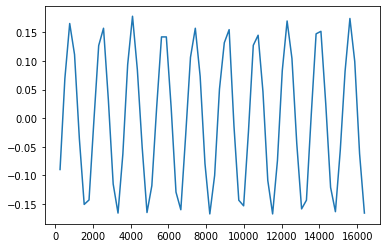

In [69]:
response = response - np.mean(response)    

import matplotlib.pyplot as plt 
plt.plot(drive_duration,np.real(response))

In [94]:
drive_duration,np.real(response)

(array([  256.,   512.,   768.,  1024.,  1280.,  1536.,  1792.,  2048.,
         2304.,  2560.,  2816.,  3072.,  3328.,  3584.,  3840.,  4096.,
         4352.,  4608.,  4864.,  5120.,  5376.,  5632.,  5888.,  6144.,
         6400.,  6656.,  6912.,  7168.,  7424.,  7680.,  7936.,  8192.,
         8448.,  8704.,  8960.,  9216.,  9472.,  9728.,  9984., 10240.,
        10496., 10752., 11008., 11264., 11520., 11776., 12032., 12288.,
        12544., 12800., 13056., 13312., 13568., 13824., 14080., 14336.,
        14592., 14848., 15104., 15360., 15616., 15872., 16128., 16384.]),
 array([-0.08995056,  0.06922913,  0.16542053,  0.11122131, -0.03623962,
        -0.15098572, -0.14317322, -0.00547791,  0.12684631,  0.15711975,
         0.03211975, -0.11534119, -0.16612244, -0.06309509,  0.09364319,
         0.17811584,  0.08485413, -0.05088806, -0.16514587, -0.11827087,
         0.01893616,  0.14198303,  0.14198303,  0.01844788, -0.12950134,
        -0.16026306, -0.03038025,  0.1063385 ,  0.1571197

In [74]:
#drive_duration

In [75]:
#Generate the Rabi oscillation plot and find the 𝜋-pulse amplitude:
#rabi_fit = RabiFitter(sim_result, drive_duration, [qubit], fit_p0 = [1.5, 2, 0, 0])
# plot
# rabi_fit.plot(0)

In [73]:
#rabi_schedules

In [90]:
from scipy.optimize import curve_fit
def cos_fit_func(x, A,B, w, phi):
    return B + A * np.cos(2*np.pi*x*w + phi)

In [91]:
fitparams, conv = curve_fit(cos_fit_func, drive_duration, response, [0.15, 0.0, 1/2000, -(np.pi)*0.7])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [92]:
fitparams
a0,b0,w0,phi = fitparams
fitparams

array([-3.64281945e-02, -1.22984978e-03,  5.21270802e-04, -4.77821632e+00])

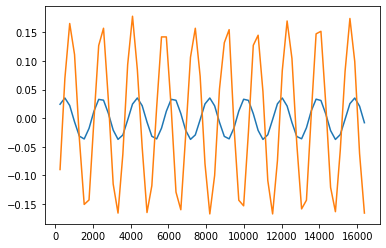

In [93]:
plt.plot(drive_duration,cos_fit_func(drive_duration,a0,b0,w0,phi),drive_duration,np.real(response))